In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.4 MB/s eta 0:00:00


In [2]:
import optuna
import xgboost as xgb
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna.visualization as vis


In [9]:
# 1. Carregar dataset covertype
data = fetch_openml(name='covertype', version=3, as_frame=True)
df = data.frame

# Converter colunas do tipo 'category' para int
cat_cols = [col for col in df.columns if str(df[col].dtype) == 'category']
for col in cat_cols:
    df[col] = df[col].astype(int)

# Criar variável binária e separar em X e y
df['binary_class'] = (df['class'] == 2).astype(int)
X = df.drop(columns=['class', 'binary_class'])
y = df['binary_class']

print(X.shape)

(581012, 54)


Número de amostras: 581012
Número de features: 54

Features do dataset:
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']

Distribuição das classes:
bi

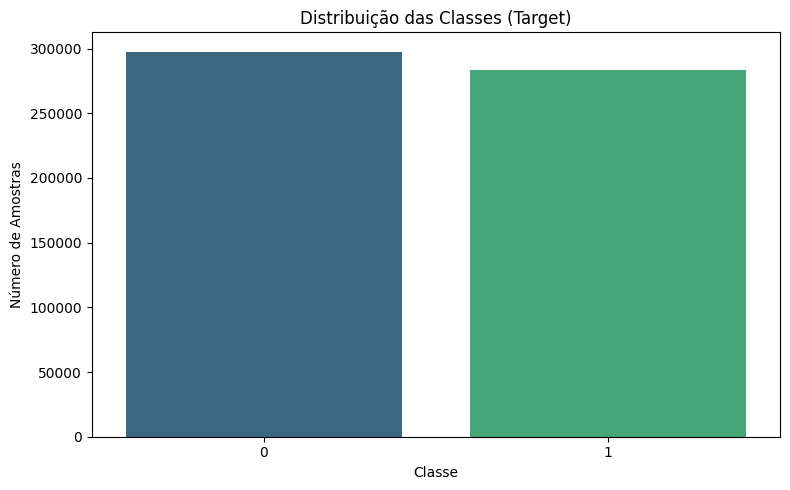

In [18]:
# 2. Informações do dataset
print(f"Número de amostras: {X.shape[0]}")
print(f"Número de features: {X.shape[1]}\n")
print("Features do dataset:")
print(X.columns.tolist())
print("\nDistribuição das classes:")
print(y.value_counts())

# Visualização da distribuição das classes (target)
df_target = pd.DataFrame({'Classe': y})
plt.figure(figsize=(8, 5))
sns.countplot(data=df_target, x='Classe', hue='Classe', palette="viridis", legend=False)
plt.title("Distribuição das Classes (Target)")
plt.xlabel("Classe")
plt.ylabel("Número de Amostras")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
# 3. Dividir treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (464809, 54)
X_test shape: (116203, 54)


In [20]:
### Modelo padrão ###

# Instanciar o modelo
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# Treinar
model.fit(X_train, y_train)

# Prever
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Avaliar
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Accuracy: 0.8770



📄 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     59543
           1       0.86      0.89      0.88     56660

    accuracy                           0.88    116203
   macro avg       0.88      0.88      0.88    116203
weighted avg       0.88      0.88      0.88    116203



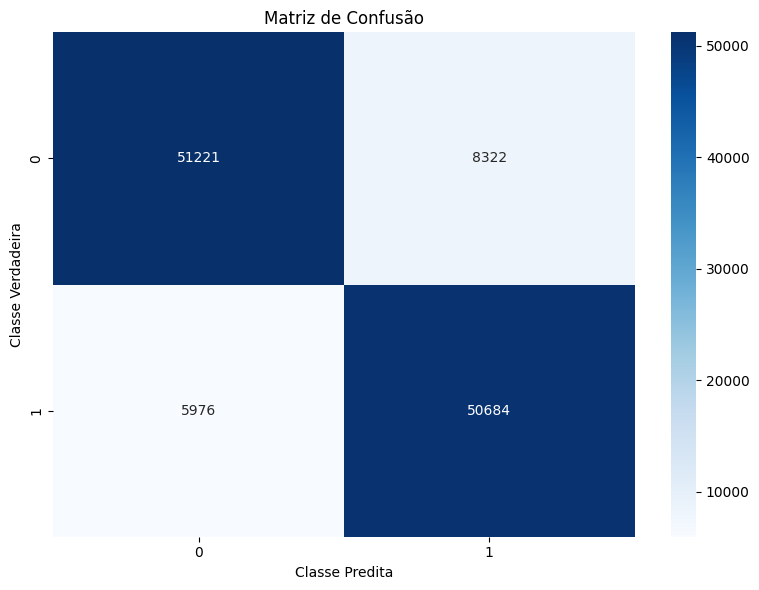

In [21]:
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Verdadeira")
plt.tight_layout()
plt.show()

In [22]:
### Optuna - função objetivo

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "seed": 42,
        "verbosity": 0,
    }

    model = xgb.XGBClassifier(**params)

    # Cross-validation no conjunto de treino
    scores = cross_val_score(model, X_train, y_train, cv=4, scoring='accuracy')
    return scores.mean()

In [23]:
### Optuna - rodar estudo

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Melhor acurácia:", study.best_value)
print("Melhores parâmetros:", study.best_params)

[I 2025-10-11 17:06:30,240] A new study created in memory with name: no-name-1b918192-44ba-4ddc-85d1-0899ac5a7515
[I 2025-10-11 17:07:08,230] Trial 0 finished with value: 0.8286414497561806 and parameters: {'n_estimators': 171, 'reg_lambda': 0.00045924119168921397, 'reg_alpha': 0.09288666024648042, 'max_depth': 4, 'learning_rate': 0.2302600734592866, 'gamma': 7.975754155646517}. Best is trial 0 with value: 0.8286414497561806.
[I 2025-10-11 17:08:24,750] Trial 1 finished with value: 0.9019081009418968 and parameters: {'n_estimators': 185, 'reg_lambda': 0.005416086976485715, 'reg_alpha': 0.11243651930629003, 'max_depth': 10, 'learning_rate': 0.053513338632630476, 'gamma': 4.15361899520632}. Best is trial 1 with value: 0.9019081009418968.
[I 2025-10-11 17:09:21,353] Trial 2 finished with value: 0.8161029593935596 and parameters: {'n_estimators': 99, 'reg_lambda': 0.12366087849798935, 'reg_alpha': 0.019220190710004307, 'max_depth': 10, 'learning_rate': 0.001240208387027803, 'gamma': 4.9452

Melhor acurácia: 0.9518597937297766
Melhores parâmetros: {'n_estimators': 176, 'reg_lambda': 0.006682813099489188, 'reg_alpha': 0.1391003985117472, 'max_depth': 10, 'learning_rate': 0.1991699107731723, 'gamma': 0.5770235504935204}


In [24]:
### Modelo otimizado ###

# Pegar os melhores parâmetros
best_params = study.best_params

# Fixar parâmetros que não estavam na busca
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "use_label_encoder": False,
    "seed": 42,
    "verbosity": 0
})

# Instanciar o modelo com os melhores parâmetros
model_best = xgb.XGBClassifier(**best_params)

# Treinar o modelo no conjunto inteiro de treino (sem early stopping agora)
model_best.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = model_best.predict(X_test)

# Avaliar acurácia
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia no teste com melhores hiperparâmetros: {acc:.4f}")

Acurácia no teste com melhores hiperparâmetros: 0.9570



📄 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     59543
           1       0.95      0.97      0.96     56660

    accuracy                           0.96    116203
   macro avg       0.96      0.96      0.96    116203
weighted avg       0.96      0.96      0.96    116203



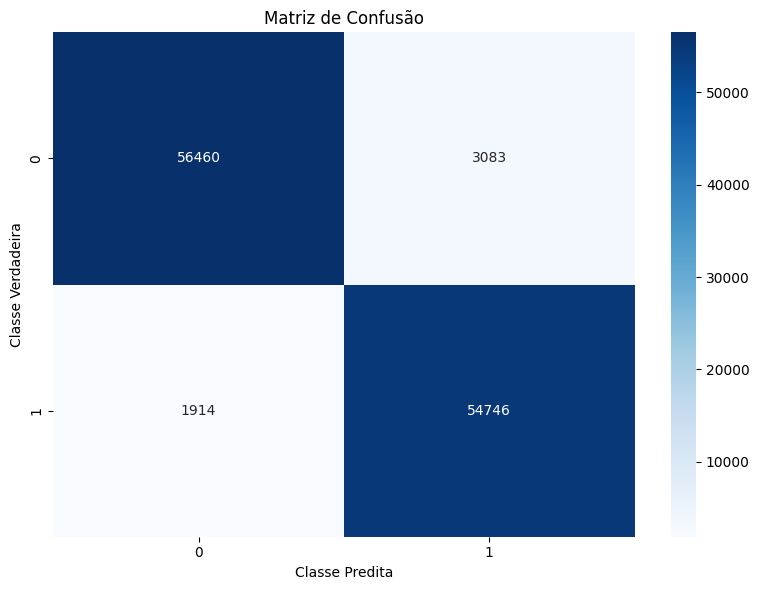

In [25]:
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Verdadeira")
plt.tight_layout()
plt.show()

In [26]:
# Histórico da acurácia
vis.plot_optimization_history(study).show()
vis.plot_optimization_history(study).write_html("optimization_history.html")

# Importância dos hiperparâmetros
vis.plot_param_importances(study).show()
vis.plot_param_importances(study).write_html("param_importance.html")

# Coordenadas paralelas (relações entre parâmetros)
vis.plot_parallel_coordinate(study).show()
vis.plot_parallel_coordinate(study).write_html("parallel_coordinate.html")

# Distribuição dos parâmetros
vis.plot_slice(study).show()
vis.plot_slice(study).write_html("slice.html")